*First compiled on May 23, 2017.*

# Lineage Tree of Planaria (Plass, Solana *et al.*, 2017)

This example is discussed in detail in the original publication (Plass, Solana *et al.*, 2017). Here, we focus only on the technical aspects of the inference of the abstracted graph.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
# we will soon provide an update with more recent dependencies
sc.logging.print_versions_dependencies_numerics()
results_file = './write/nestorowa16.h5'

Running Scanpy 0.3.2 on 2017-11-29 23:04.
Dependencies: numpy==1.13.3 scipy==1.0.0 pandas==0.21.0 scikit-learn==0.18.2 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.5.2+274.g35181a7 


## Reading the data

We use Seurat's preprocessing as performed by M. Plass.

In [2]:
adata_seurat = sc.read('./data/X_pca_seurat.txt', cache=True)
annotation = pd.read_csv('./data/X_annotation_seurat.txt', delimiter=' ')
adata_seurat.smp['clusters'] = annotation['ident']
adata_seurat.uns['iroot'] = 0  # root cell (some random stem cell)

reading cache ./write/data/X_pca_seurat.h5


Reproduce the exact same coloring as in Plass, Solana *et al.* (2017).

In [3]:
order = pd.read_csv('./data/legend_order_mireya.txt', delimiter=' ')['x'].values.astype(str)
colors = np.genfromtxt('./data/new_colors_mireya.txt', dtype=str, comments='%')
idcs = np.argsort(order)
sorted_order = order[idcs]
sorted_colors = colors[idcs]
adata_seurat.uns['clusters_order'] = sorted_order
# all of the following are not valid matplotlib colors, so replace them with their hex codes
hex_codes = {'gold2': '#eec900', 'firebrick3': '#cd2626', 'khaki2': '#eee685', 'slategray3': '#9fb6cd',
            'palegreen3': '#7ccd7c', 'tomato2': '#ee5c42', 'grey80': '#cccccc', 'grey90': '#e5e5e5',
            'wheat4': '#8b7e66', 'grey65': '#a6a6a6', 'grey10': '#1a1a1a', 'grey20': '#333333', 'grey50': '#7f7f7f', 'grey30': '#4d4d4d',
             'grey40': '#666666', 'antiquewhite2': '#eedfcc', 'grey77': '#c4c4c4', 'snow4': '#8b8989',
             'chartreuse3': '#66cd00', 'yellow4': '#8b8b00', 'darkolivegreen2': '#bcee68',
            'olivedrab3': '#9acd32', 'azure3': '#c1cdcd', 'violetred': '#d02090',
             'mediumpurple3': '#8968cd', 'purple4': '#551a8b', 'seagreen4': '#2e8b57'}
adata_seurat.uns['clusters_colors'] = [c if c not in hex_codes else hex_codes[c] for c in sorted_colors]

## Visualization

In [4]:
sc.tl.tsne(adata_seurat)
sc.write('planaria_seurat', adata_seurat)

computing tSNE
    using data matrix X directly (no PCA)
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:48.010) --> added
    'X_tsne', tSNE coordinates (adata.smp)


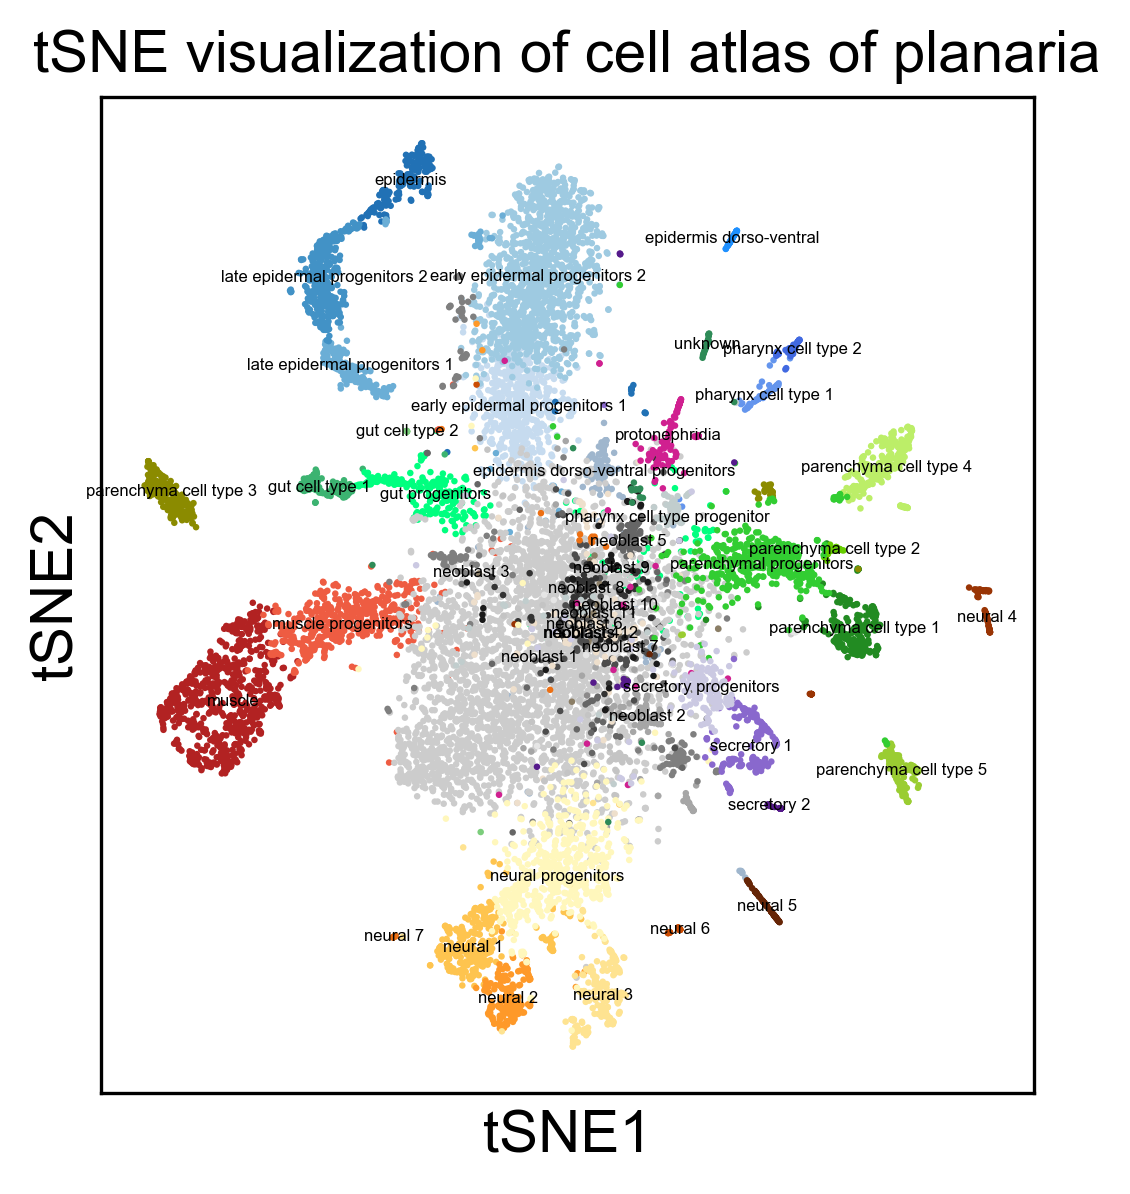

In [5]:
adata_seurat = sc.read('planaria_seurat')
sc.settings.file_format_figs = 'svg'
sc.settings.set_figure_params(dpi=150)
ax = sc.pl.tsne(adata_seurat,
                title='tSNE visualization of cell atlas of planaria',
                color='clusters', legend_loc='on data', legend_fontsize=4)

## Relating the subgoups using graph abstraction

Use the Louvain clustering as implemented in Seurat to define the groups that correspond to nodes in the abstracted graph.

In [6]:
adata = sc.read('planaria_seurat')
sc.tl.aga(adata, groups='clusters', n_neighbors=10, n_dcs=15,
          attachedness_measure='random_walk', tree_detection='iterative_matching')
sc.write('planaria_seurat', adata)

running Approximate Graph Abstraction (AGA)
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 10 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9979305863  0.9962913394  0.9960985184  0.9959969521
      0.9955072999  0.9951480031  0.9950487614  0.9943813086  0.9937173128
      0.9904315472  0.9896133542  0.9879560471  0.9870309234  0.9863759279]
    abstracted graph will have 46 nodes
    finished (0:00:44.986) --> added
    aga_adjacency_full_attachedness : np.ndarray (adata.uns)
        The full adjacency matrix of the abstracted graph, weights
        correspond to connectedness.
    aga_adjacency_full_confidence : np.ndarray (adata.uns)
        The full adjacency matrix of the abstracted graph, weights
        correspond to confidence in the presence of an edge.
    aga_adjacency_tree_confidence : sc.sparse csr matrix (adata.uns)
        The adjace

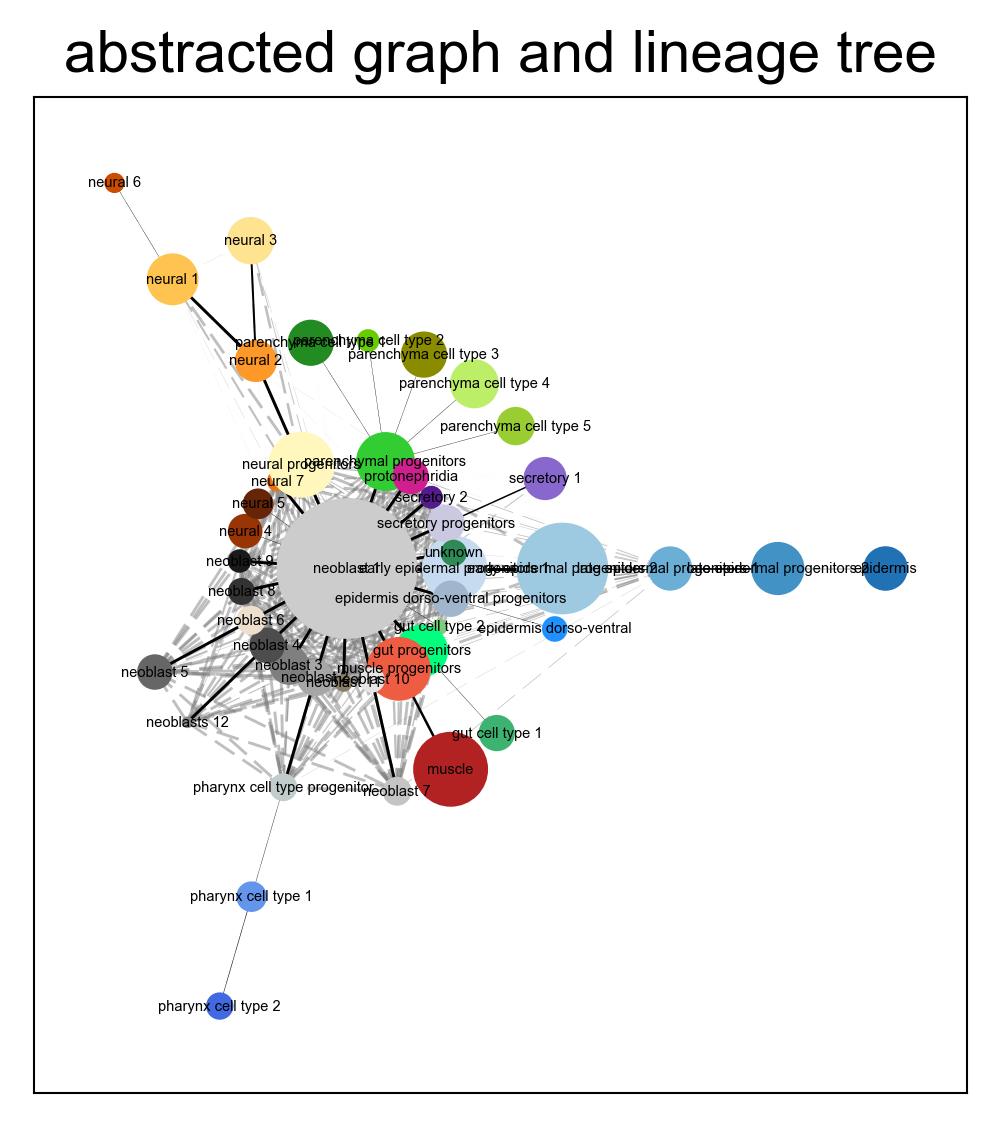

In [3]:
adata = sc.read('planaria_seurat')
rcParams['axes.linewidth'] = 0.5
sc.settings.set_figure_params(dpi=150)
_, pos = sc.pl.aga_graph(
    adata,
    title='abstracted graph and lineage tree',
    root='neoblast 1',
    layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=3.5,
    return_pos=True)

Rotate the layout by 150 degrees.

In [4]:
theta = np.radians(150)
c, s = np.cos(theta), np.sin(theta)
r = np.array([[c, -s], [s, c]])
pos = r.dot(pos.T).T

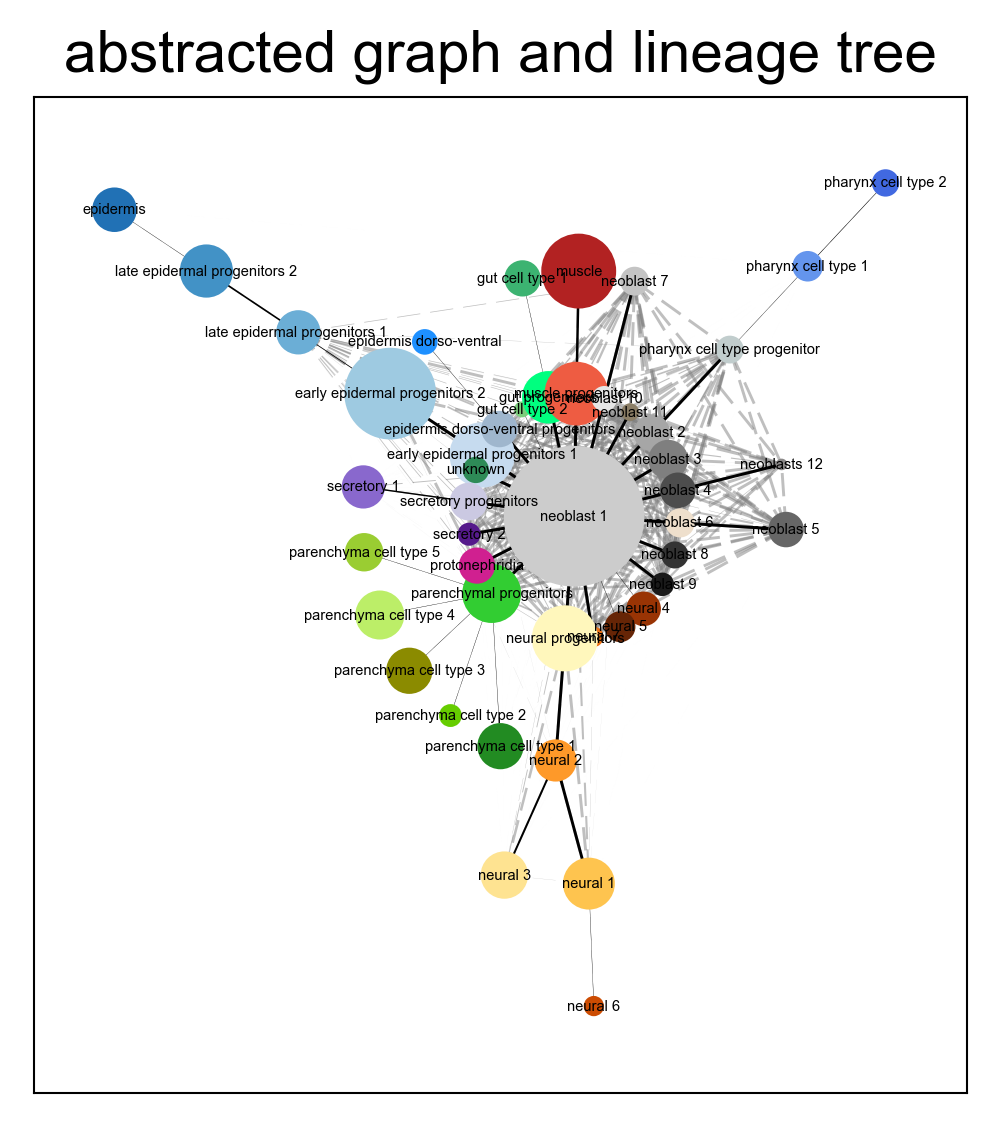

In [5]:
ax = sc.pl.aga_graph(
    adata,
    title='abstracted graph and lineage tree',
    root='neoblast 1',
    pos=pos,
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=3.5)

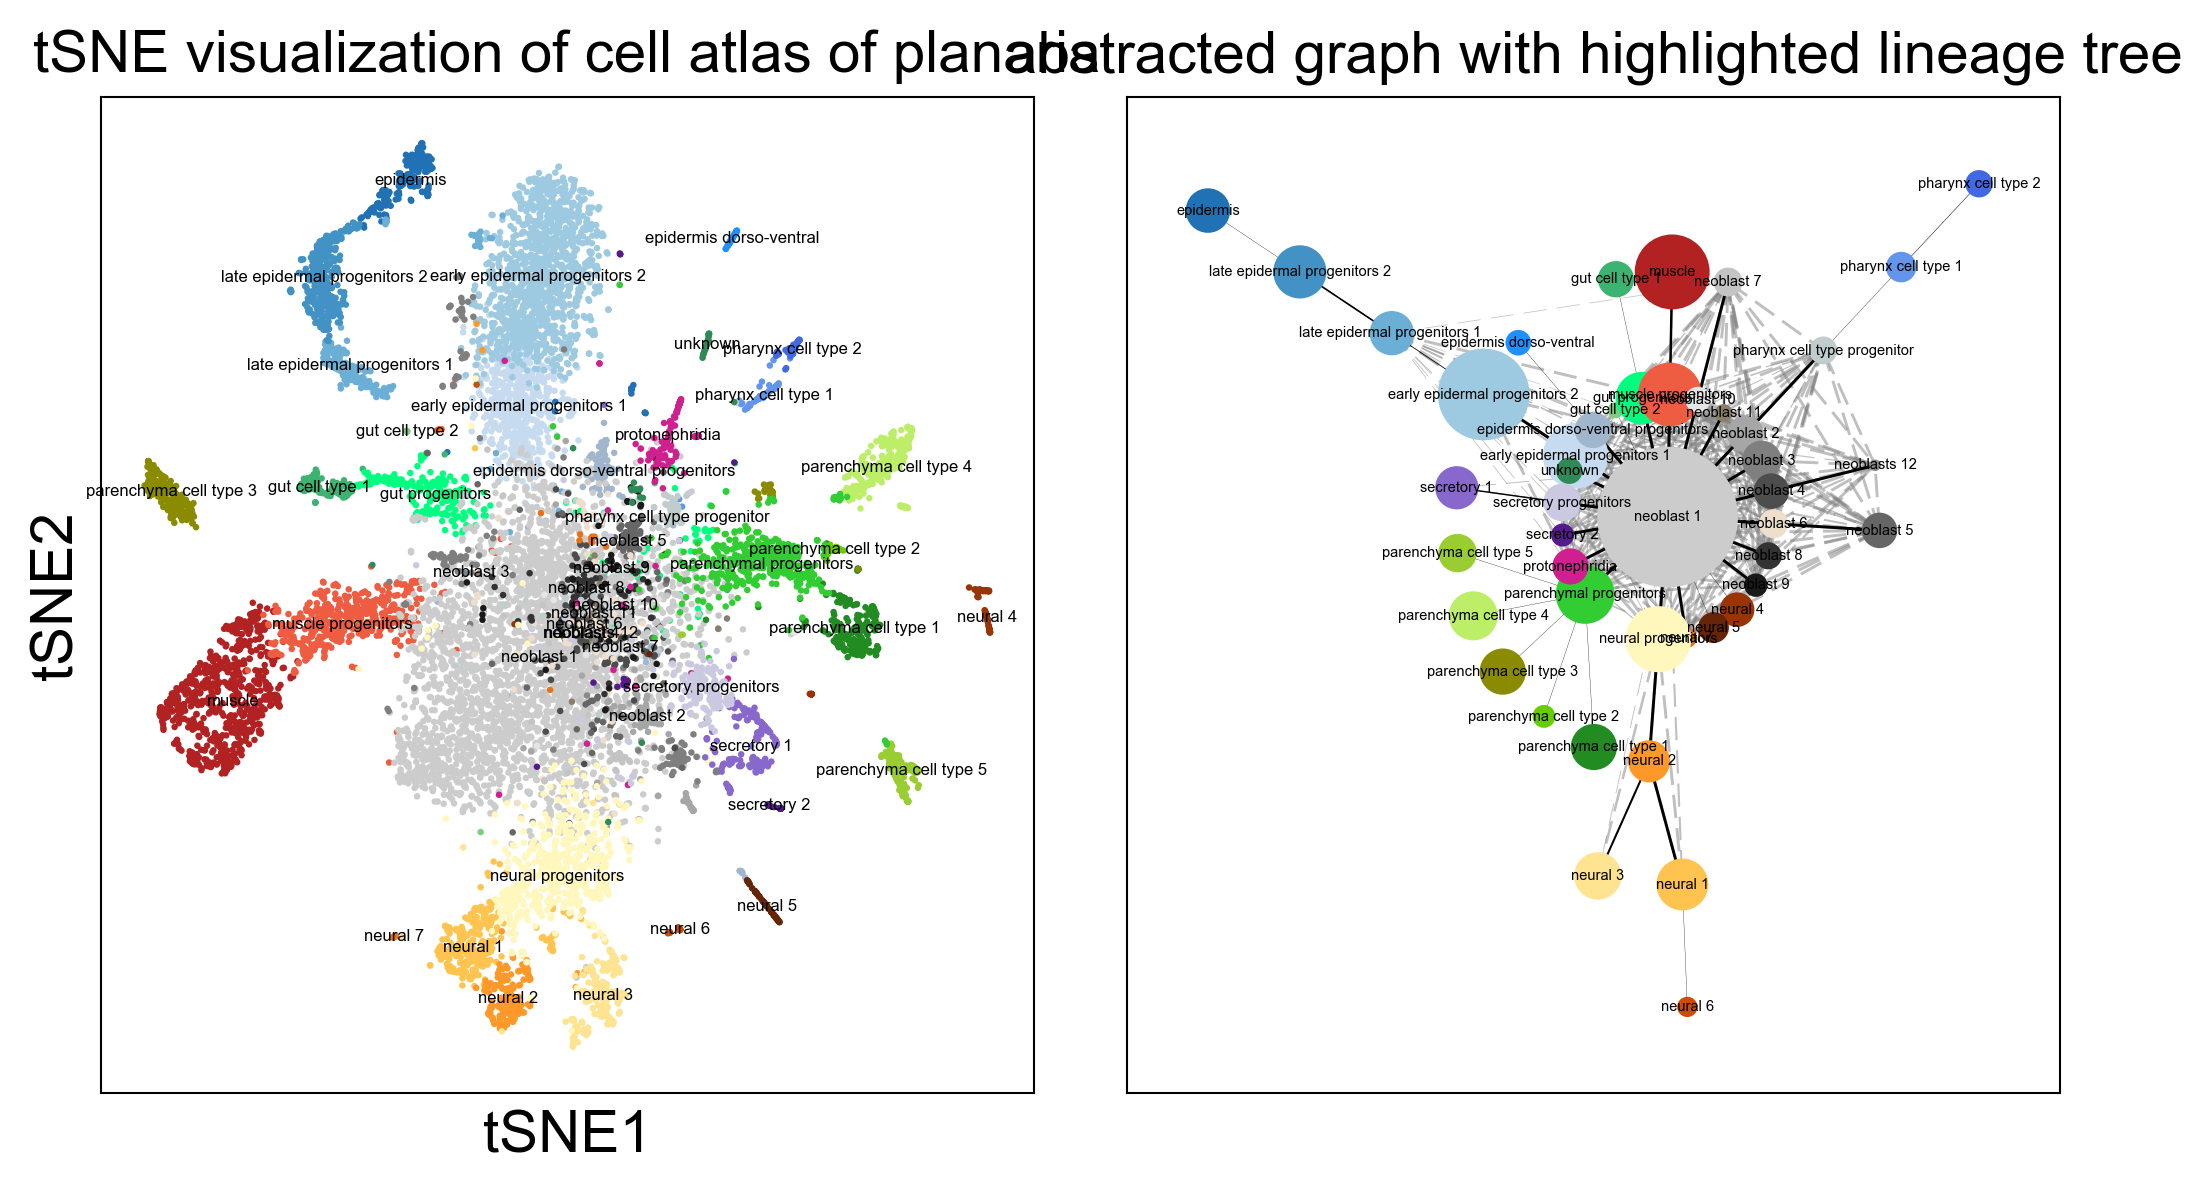

In [6]:
ax = sc.pl.aga(
    adata,
    title='tSNE visualization of cell atlas of planaria',
    color='clusters', legend_fontsize=4,
    title_graph='abstracted graph with highlighted lineage tree',    
    root='neoblast 1',
    pos=pos,
    threshold_dashed=0.1,
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=3.5)

## Color by degree of the abstracted graph

... you are using a very low resolution for saving figures, adjusting to dpi=300
saving figure to file ./figures/aga_graph_degrees.svg


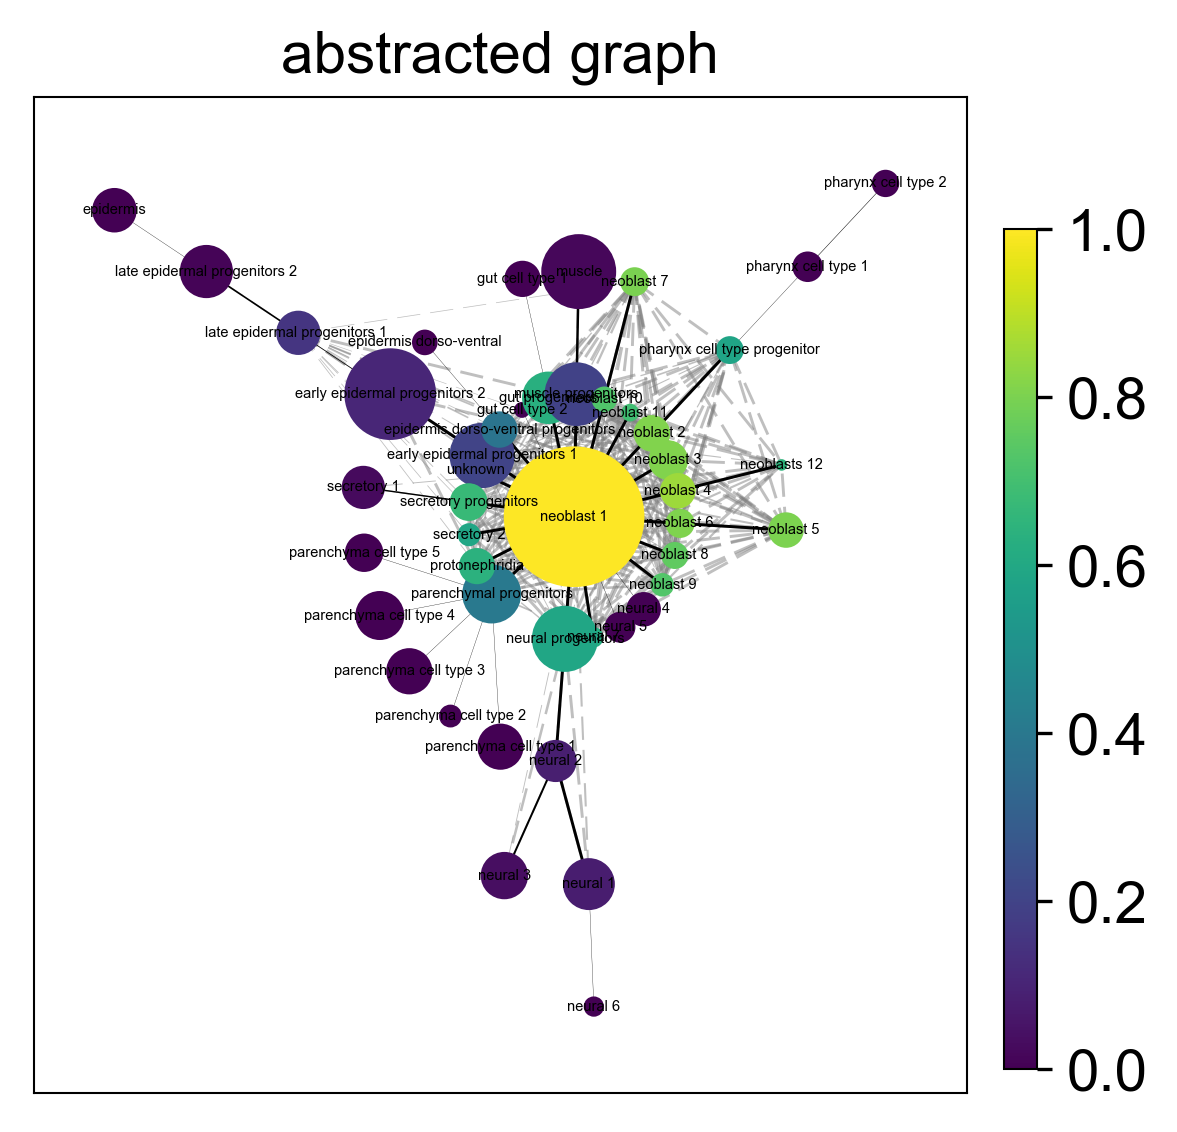

In [7]:
adata = sc.read('planaria_seurat')
ax = sc.pl.aga_graph(
    adata,
    color='degree_dashed',
    root='neoblast 1',
    pos=pos,
    threshold_dashed=0.1,
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=3.5,
    cmap='viridis',
    save='_degrees',
    ext='svg', show=True)

## Compute and plot the expression entropies


saving figure to file ./figures/aga_graph_entropies.svg


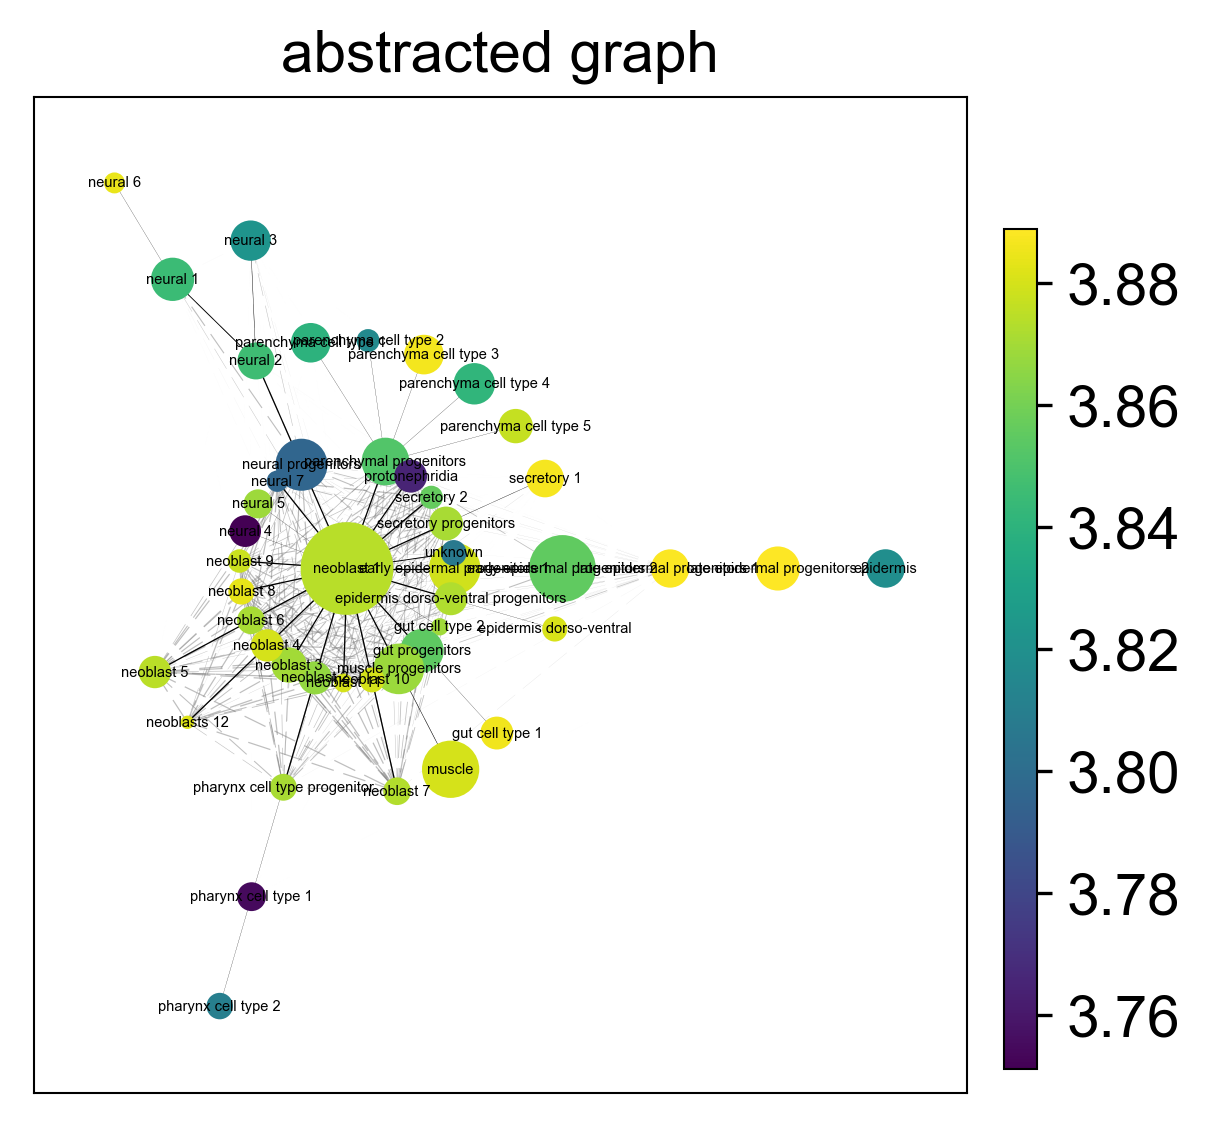

In [8]:
adata = sc.read('planaria_seurat')
entropies = sc.tl.aga_expression_entropies(adata)
ax = sc.pl.aga_graph(
    adata,
    color=entropies,
    root='neoblast 1',
    layout='rt_circular',
    node_size_scale=0.4,
    node_size_power=0.7,
    edge_width_scale=0.2,
    min_edge_width=0.05,
    max_edge_width=0.5,
    fontsize=3.5,
    cmap='viridis',
    save='_entropies', ext='svg', show=True)

## Exports

In [2]:
adata = sc.read('planaria_seurat')

In [3]:
adata.smp[['clusters', 'aga_pseudotime']].to_csv('./write/aga_groups_pseudotime.csv')

In [4]:
np.savetxt('./write/aga_groups_ordered_names.csv',
           adata.smp['clusters'].cat.categories, fmt='%s')

In [5]:
np.savetxt('./write/aga_adjacency_full.txt', adata.uns['aga_adjacency_full_confidence'])

In [6]:
from scipy.io import mmwrite
mmwrite('./write/aga_adjacency_tree.mtx', adata.uns['aga_adjacency_tree_confidence'])

In [7]:
entropies = sc.tl.aga_expression_entropies(adata)

In [8]:
np.savetxt('./write/aga_expression_entropies.txt', entropies)

In [9]:
degrees = sc.tl.aga_degrees(adata)
degrees = (degrees - np.min(degrees)) / (np.max(degrees) - np.min(degrees)) 

In [10]:
np.savetxt('./write/aga_expression_degrees.txt', degrees)

## Supplemental Notes

Here, we present further analyses.

### Visualize data using graph drawing

In [28]:
adata_seurat = sc.read('planaria_seurat')
ax = sc.tl.draw_graph(adata_seurat, n_neighbors=10)
sc.write('planaria_seurat', adata_seurat)

drawing single-cell graph using layout "fr"
    using data matrix X directly for building graph (no PCA)
    using stored data graph with n_neighbors = 10 and spectrum
    [ 1.            0.9979305863  0.9962913394  0.9960985184  0.9959969521
      0.9955072999  0.9951480031  0.9950487614  0.9943813086  0.9937173128
      0.9904315472  0.9896133542  0.9879560471  0.9870309234  0.9863759279]
    finished (0:16:35.429) and added
    "X_draw_graph_fr", graph_drawing coordinates (adata.smp)
    "draw_graph_params", the parameters (adata.uns)


In [29]:
sc.settings.set_figure_params(dpi=150)
sc.plotting.reset_rcParams(fontsize=10)
rcParams['axes.linewidth'] = 0.4

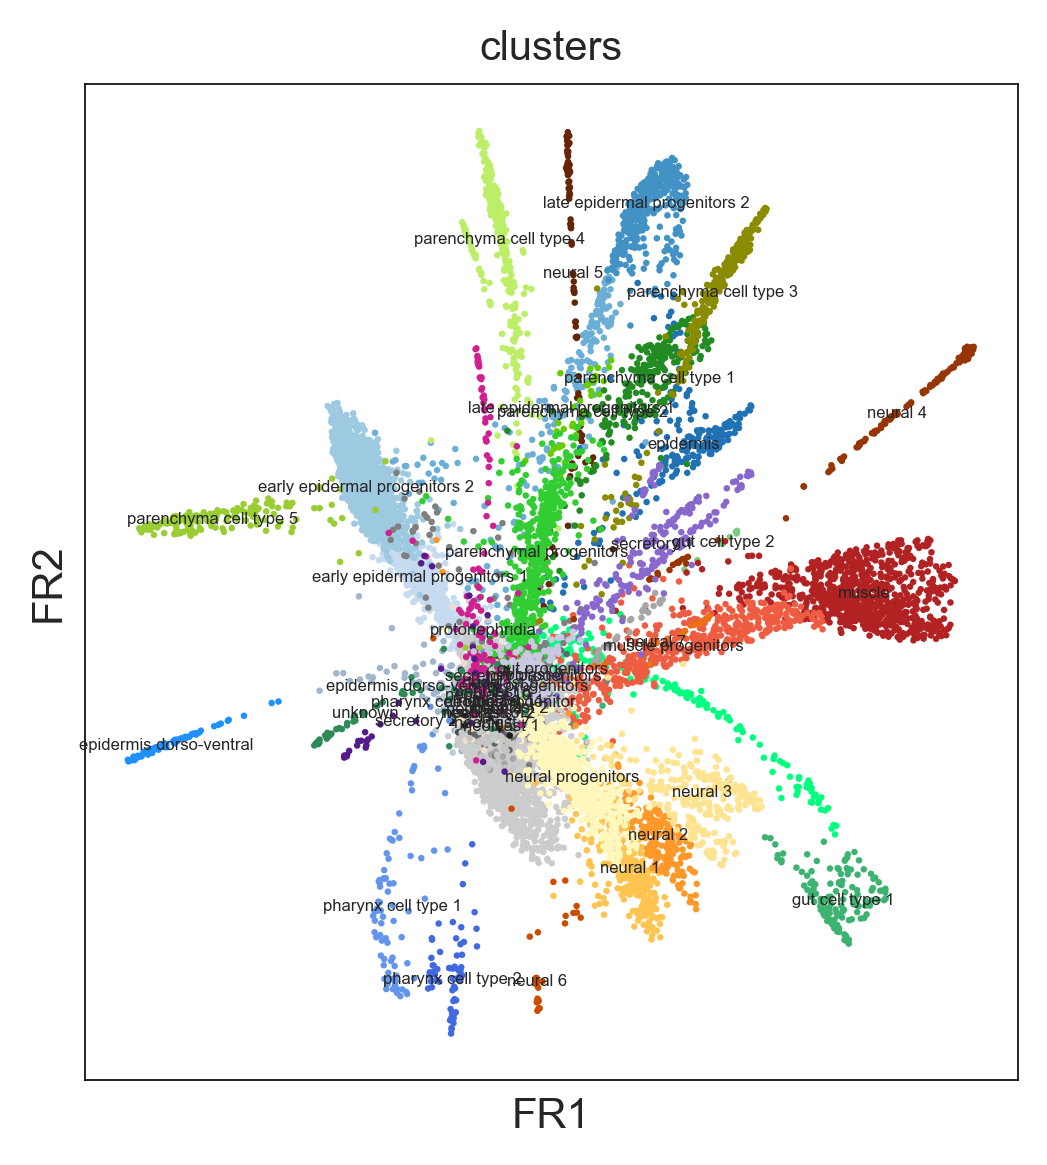

In [30]:
ax = sc.pl.draw_graph(adata_seurat, color='clusters', legend_loc='on data', legend_fontsize=4)

This is to illustrate that the tree structure of the data needs to be revealed and is not available with naive methods.

In [31]:
adata_seurat = sc.read('planaria_seurat')
sc.tl.draw_graph(adata_seurat, n_neighbors=10, layout='rt_circular', root=0)
sc.write('planaria_seurat', adata_seurat)

drawing single-cell graph using layout "rt_circular"
    using data matrix X directly for building graph (no PCA)
    using stored data graph with n_neighbors = 10 and spectrum
    [ 1.            0.9979305863  0.9962913394  0.9960985184  0.9959969521
      0.9955072999  0.9951480031  0.9950487614  0.9943813086  0.9937173128
      0.9904315472  0.9896133542  0.9879560471  0.9870309234  0.9863759279]
    finished (0:00:02.521) and added
    "X_draw_graph_rt_circular", graph_drawing coordinates (adata.smp)
    "draw_graph_params", the parameters (adata.uns)


saving figure to file ./figures/draw_graph_rt_circular_labels_on_data.svg


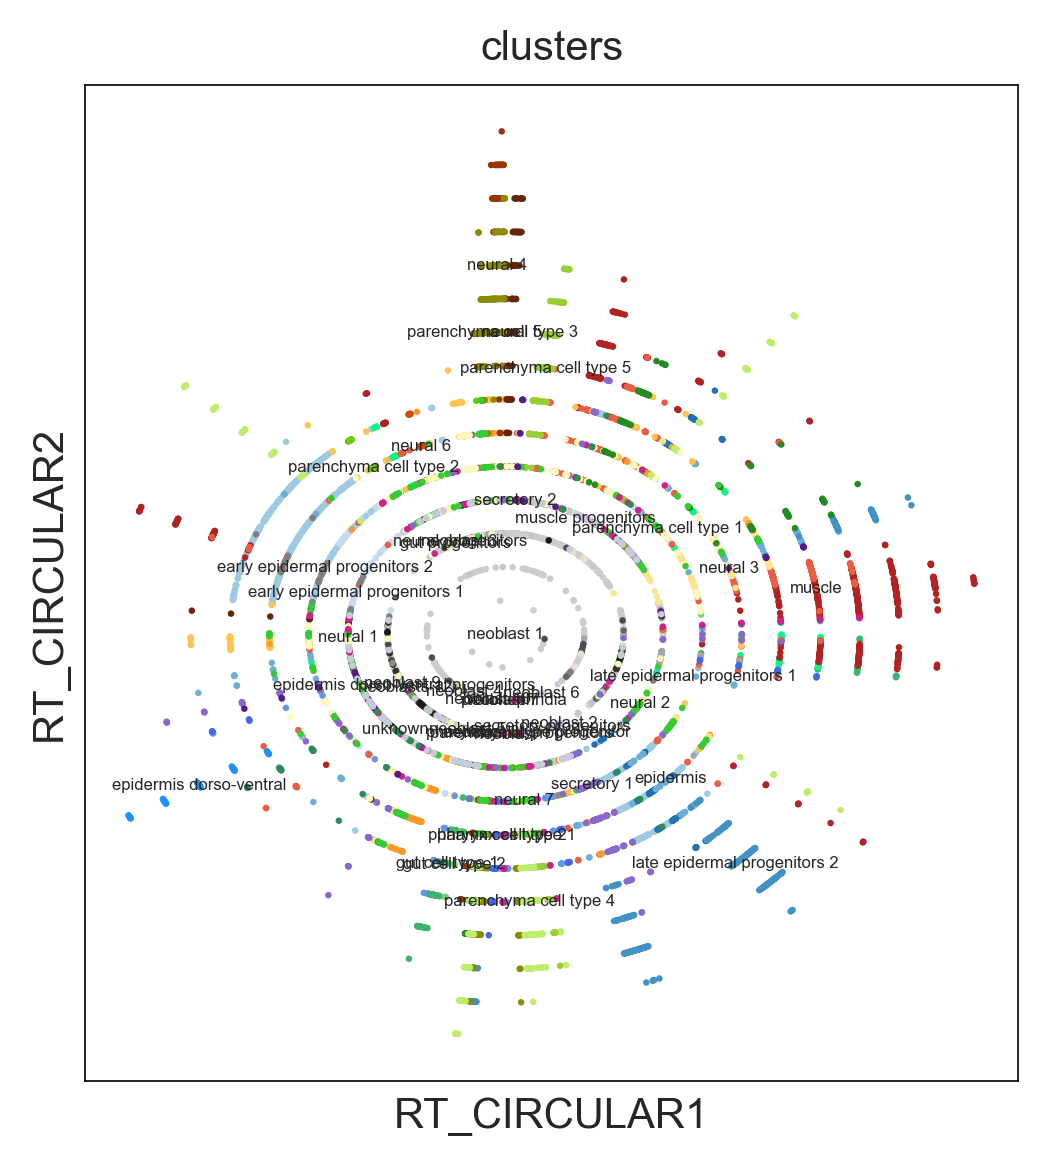

In [32]:
ax = sc.pl.draw_graph(adata_seurat, color='clusters', legend_loc='on data', legend_fontsize=4,
                      show=True, save='_labels_on_data')

## Using default parameters

The result is similar to the one observed above.

In [34]:
adata = sc.read('planaria_seurat')
sc.tl.aga(adata, groups='clusters', n_neighbors=10, n_dcs=15)

running Approximate Graph Abstraction (AGA)
    using data matrix X directly for building graph (no PCA)
    using stored data graph with n_neighbors = 10 and spectrum
    [ 1.            0.9979305863  0.9962913394  0.9960985184  0.9959969521
      0.9955072999  0.9951480031  0.9950487614  0.9943813086  0.9937173128
      0.9904315472  0.9896133542  0.9879560471  0.9870309234  0.9863759279]
    abstracted graph will have 46 nodes
    finished (0:00:03.193): --> added
    aga_adjacency_full_attachedness : np.ndarray (adata.uns)
        The full adjacency matrix of the abstracted graph, weights
        correspond to connectedness.
    aga_adjacency_full_confidence : np.ndarray (adata.uns)
        The full adjacency matrix of the abstracted graph, weights
        correspond to confidence in the presence of an edge.
    aga_adjacency_tree_confidence : sparse csr matrix (adata.uns)
        The adjacency matrix of the tree-like subgraph that best explains
        the topology
    aga_groups 

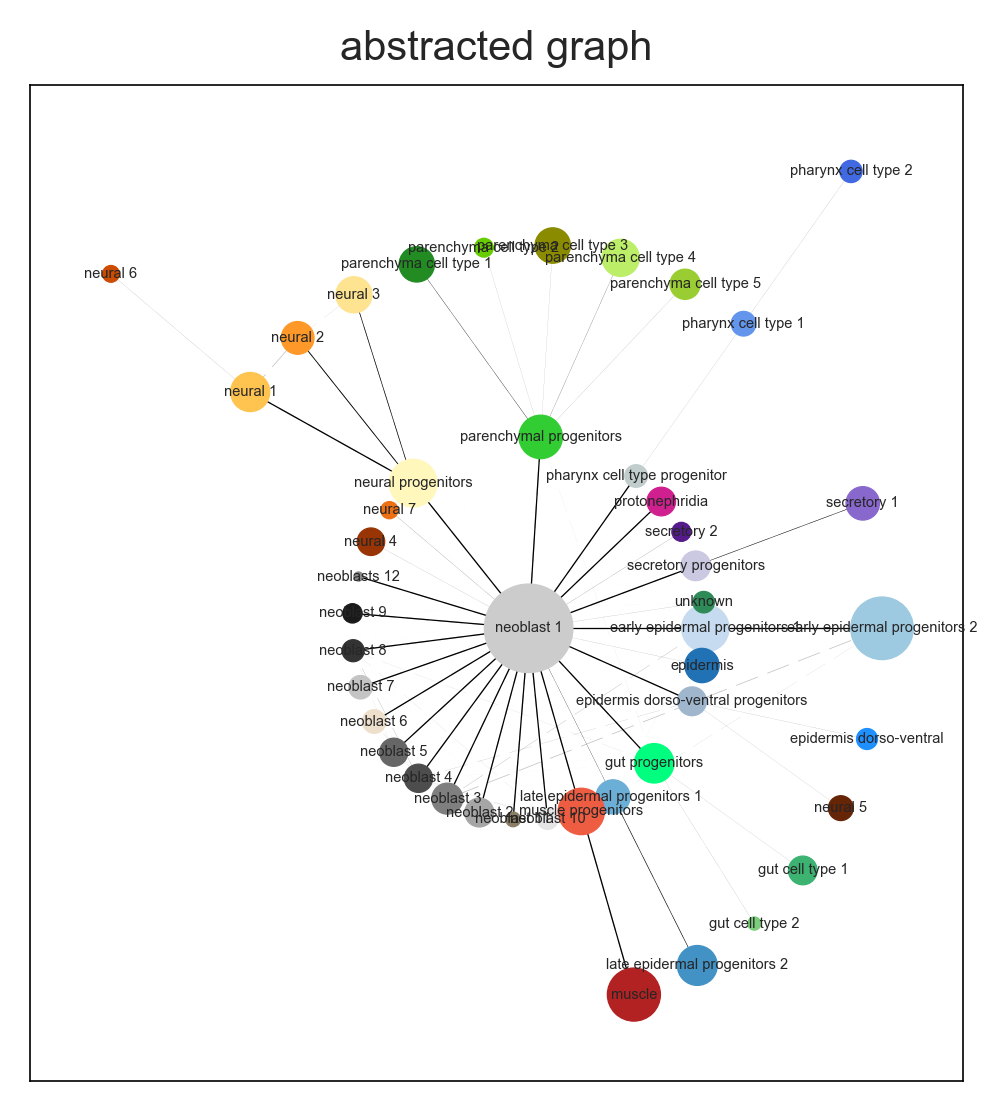

In [35]:
ax = sc.pl.aga_graph(adata,
                     root='neoblast 1',
                     layout='rt_circular',
                     node_size_scale=0.4,
                     node_size_power=0.7,
                     edge_width_scale=0.2,
                     fontsize=3.5)